In [1]:
import cv2
import mediapipe as mp
import numpy as np
import time
from IPython.display import display, Image, clear_output

def video_show(frame, width=400, height=400):
    _, buffer = cv2.imencode(".jpg", frame)
    clear_output(wait=True)
    display(Image(data=buffer, width=width, height=height))

2025-03-27 09:56:29.337714: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743036989.353599  477061 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743036989.358603  477061 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743036989.370819  477061 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743036989.370834  477061 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743036989.370836  477061 computation_placer.cc:177] computation placer alr

In [ ]:
def calculate_angle(a, b, c):
    a = np.array(a)
    b = np.array(b)
    c = np.array(c)
    ba = a - b
    bc = c - b
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc) + 1e-6)
    angle = np.arccos(np.clip(cosine_angle, -1.0, 1.0))
    return np.degrees(angle)

def video_pose_estimation(video_path):
    mp_pose = mp.solutions.pose
    mp_drawing = mp.solutions.drawing_utils
    cap = cv2.VideoCapture(video_path)
    pose = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5, min_tracking_confidence=0.5)

    points = [
        11, 12, 13, 14, 15, 16, 23, 24, 25, 26, 27, 28
    ]

    angle_joints = [
        (11, 13, 15), (12, 14, 16),  # 양팔
        (23, 25, 27), (24, 26, 28),  # 양다리
        (13, 11, 23), (14, 12, 24),  # 상체
        (11, 23, 25), (12, 24, 26),  # 골반
    ]

    while True:
        ret, frame = cap.read()
        if not ret: break

        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = pose.process(image)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        if results.pose_landmarks is None: continue

        lm = results.pose_landmarks.landmark

        # 기준점
        neck_x = (lm[11].x + lm[12].x) / 2
        neck_y = (lm[11].y + lm[12].y) / 2
        
        for idx in points:
            x = lm[idx].x - neck_x
            y = lm[idx].y - neck_y
            
            text_x = int(lm[idx].x * image.shape[1])
            text_y = int(lm[idx].y * image.shape[0])

            if idx % 2 == 0:
                offset = -300
            else:
                offset = 10

            cv2.putText(image, f"x:{round(x, 3)}, y:{round(y, 3)}", (text_x + offset, text_y + 20), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

        cv2.circle(image, (int(neck_x * image.shape[1]), int(neck_y * image.shape[0])), 4, (255,0,0), -1)

        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)
        video_show(image, width=640, height=640)

    pose.close()
    cap.release()

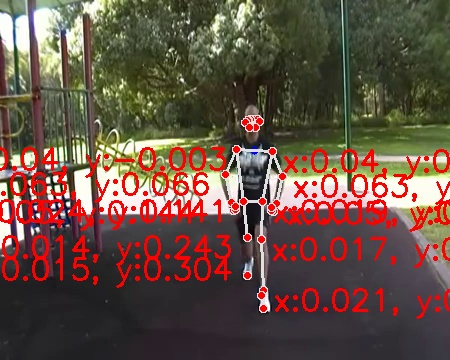

KeyboardInterrupt: 

In [ ]:
video_name = "2"
path = "/home/shin/Videos/" + video_name + ".mp4"
video_pose_estimation(path)